In [1]:
from pyfiles.nonftsteane import *

In [2]:
n = 15

angle = np.linspace(0,1,n+2)
angle = np.delete(angle, [n+1])
angle = np.delete(angle, [0])

a, b = [], []
with open("text/unitary{}.txt".format(n), "r") as file:
    for line in file:
        a.append(list(map(str, line.strip().split(","))))
with open("text/adjunitary{}.txt".format(n), "r") as file:
    for line in file:
        b.append(list(map(str, line.strip().split(","))))

In [2]:
qc = code_goto()

H_L(qc, 0)
#qec(qc, 0)
##T_L(qc, 0)
#CNOT_L(qc,0)
#qec(qc, 0)
H_L(qc, 1)

zeros, ones, pre , post = readout(qc, 1, 1000, 0.00)

print("Preselection discarded: ", pre*100, "%")
print("Postselection discarded: ", post*100, "%")
print("Accepted 0: ", zeros*100, "%")
print("Accepted 1: ", ones*100, "%")
print("Total discarded: ", (pre+post)*100, "%")
print("Succesrate: ", zeros/(ones+zeros))

Preselection discarded:  0.0 %
Postselection discarded:  0.0 %
Accepted 0:  49.8 %
Accepted 1:  50.2 %
Total discarded:  0.0 %
Succesrate:  0.498


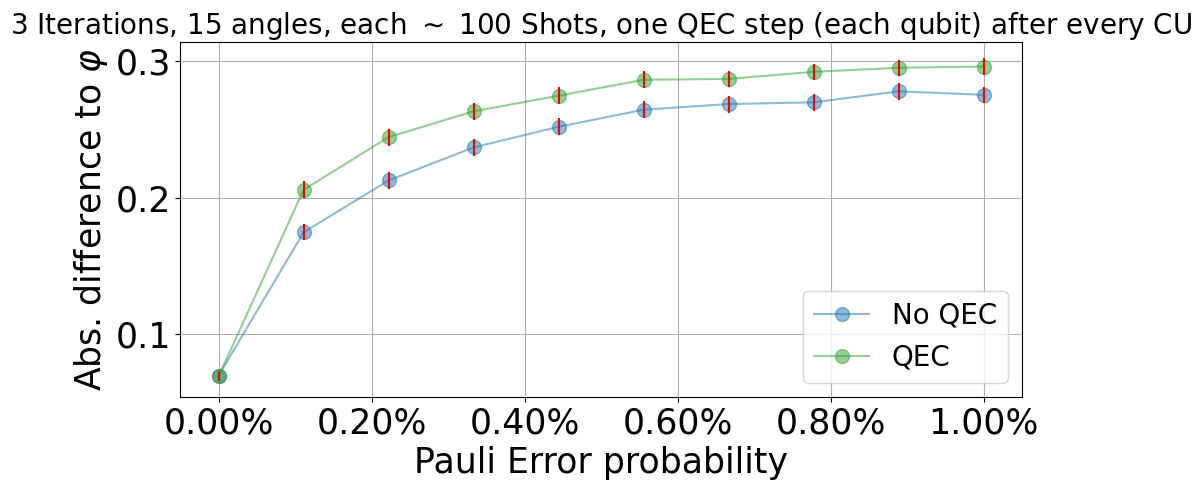

In [5]:
x, y, y_qec, err, err_qec = np.loadtxt("HPC/text/nonFTSteane_a+.txt", delimiter = ",")          #QEC after every third T/Tdg

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 2))

err = [i/((100)**0.5) for i in err]
err_qec = [i/((100)**0.5)for i in err_qec]


ax1.plot(x,y, label="No QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y, yerr=err, ecolor="red", linestyle="")

ax1.plot(x,y_qec, label="QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y_qec, yerr=err_qec, ecolor="red", linestyle="")

ax1.set_title(r"3 Iterations, 15 angles, each $\sim$ 100 Shots, one QEC step (each qubit) after every CU", fontsize=20)

ax1.set_xlabel("Pauli Error probability", fontsize=25)

ax1.set_ylabel(r"Abs. difference to $\varphi$", fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=25)

ax1.grid()
ax1.legend(fontsize=20)

#fig.suptitle('Three iterations iQPE on a [12,2,4] Carbon Code', fontsize=20)
plt.tight_layout()
#plt.savefig("Figures/SteaneFinal3.png", dpi = 200)
plt.show()

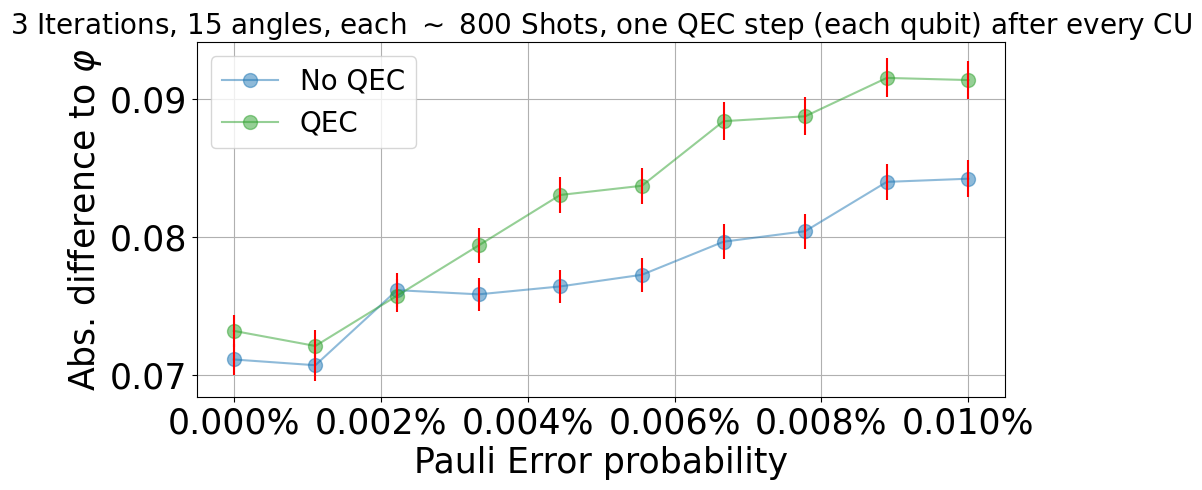

In [5]:
x, y, y_qec, err, err_qec = np.loadtxt("HPC/text/nonFTSteane_c.txt", delimiter = ",")          #QEC after every third T/Tdg

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals = 3))

err = [i/((800)**0.5) for i in err]
err_qec = [i/((800)**0.5)for i in err_qec]


ax1.plot(x,y, label="No QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y, yerr=err, ecolor="red", linestyle="")

ax1.plot(x,y_qec, label="QEC", marker = ".",markersize = 20, alpha = 0.5)
ax1.errorbar(x, y_qec, yerr=err_qec, ecolor="red", linestyle="")

ax1.set_title(r"3 Iterations, 15 angles, each $\sim$ 800 Shots, one QEC step (each qubit) after every CU", fontsize=20)

ax1.set_xlabel("Pauli Error probability", fontsize=25)

ax1.set_ylabel(r"Abs. difference to $\varphi$", fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=25)

ax1.grid()
ax1.legend(fontsize=20)

#fig.suptitle('Three iterations iQPE on a [12,2,4] Carbon Code', fontsize=20)
plt.tight_layout()
#plt.savefig("Figures/SteaneFinal3.png", dpi = 200)
plt.show()